## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], regulizer_ratio=1e-4, regulizer="l1"):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            if regulizer == "l1":
                x = keras.layers.Dense(units=n_units, 
                       activation="relu", 
                       name="hidden_layer"+str(i+1), 
                       kernel_regularizer=l1(regulizer_ratio))(input_layer)
            else:
                x = keras.layers.Dense(units=n_units, 
                       activation="relu", 
                       name="hidden_layer"+str(i+1), 
                       kernel_regularizer=l1_l2(regulizer_ratio))(input_layer)       

        else:
            if regulizer == "l1":
                x = keras.layers.Dense(units=n_units, 
                       activation="relu", 
                       name="hidden_layer"+str(i+1),
                       kernel_regularizer=l1(regulizer_ratio))(x)
            else:
                x = keras.layers.Dense(units=n_units, 
                       activation="relu", 
                       name="hidden_layer"+str(i+1),
                       kernel_regularizer=l1_l2(regulizer_ratio))(x)         
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12]
REGULIZERS = ["l1", "l1_l2"]

In [7]:
results = {}
for regulizer in REGULIZERS:
    for regulizer_ratio in L1_EXP:
        keras.backend.clear_session() # 把舊的 Graph 清掉
        print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
        model = build_mlp(input_shape=x_train.shape[1:], regulizer_ratio=regulizer_ratio, regulizer=regulizer)
        model.summary()
        optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), 
                  shuffle=True)

        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["acc"]
        valid_acc = model.history.history["val_acc"]

        exp_name_tag = "exp-{0}-{1}".format(regulizer, str(regulizer_ratio))
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}

Experiment with Regulizer = 0.010000
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Instructions for updati

50000/50000 [==============================] - 9s 172us/step - loss: 2.4626 - acc: 0.0968 - val_loss: 2.4627 - val_acc: 0.1000
Epoch 49/50
50000/50000 [==============================] - 9s 173us/step - loss: 2.4626 - acc: 0.0984 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 50/50
50000/50000 [==============================] - 9s 172us/step - loss: 2.4626 - acc: 0.0990 - val_loss: 2.4626 - val_acc: 0.1000
Experiment with Regulizer = 0.000100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (

50000/50000 [==============================] - 9s 171us/step - loss: 2.6686 - acc: 0.6279 - val_loss: 2.9782 - val_acc: 0.5201
Epoch 50/50
50000/50000 [==============================] - 8s 170us/step - loss: 2.6332 - acc: 0.6306 - val_loss: 2.9524 - val_acc: 0.5170
Experiment with Regulizer = 0.000000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 1

50000/50000 [==============================] - 9s 171us/step - loss: 0.8746 - acc: 0.6931 - val_loss: 1.4864 - val_acc: 0.5079
Experiment with Regulizer = 0.000000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
__________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 11s 212us/step - loss: 197.7455 - acc: 0.2282 - val_loss: 35.9100 - val_acc: 0.2605
Epoch 2/50
50000/50000 [==============================] - 10s 200us/step - loss: 15.9001 - acc: 0.1110 - val_loss: 5.1349 - val_acc: 0.1000
Epoch 3/50
50000/50000 [==============================] - 10s 199us/step - loss: 3.2132 - acc: 0.1000 - val_loss: 2.4716 - val_acc: 0.1000
Epoch 4/50
50000/50000 [==============================] - 10s 198us/step - loss: 2.4632 - acc: 0.0988 - val_loss: 2.4623 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 10s 201us/step - loss: 2.4624 - acc: 0.0970 - val_loss: 2.4622 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 10s 208us/step - loss: 2.4624 - acc: 0.0970 - val_loss: 2.4621 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 10s 203us/step - loss: 2.4623 - acc: 0.0979 - val_loss

50000/50000 [==============================] - 10s 210us/step - loss: 18.8294 - acc: 0.2775 - val_loss: 17.3837 - val_acc: 0.3335
Epoch 2/50
50000/50000 [==============================] - 10s 200us/step - loss: 16.1581 - acc: 0.3614 - val_loss: 14.9930 - val_acc: 0.3756
Epoch 3/50
50000/50000 [==============================] - 10s 200us/step - loss: 13.9706 - acc: 0.3850 - val_loss: 12.9924 - val_acc: 0.3841
Epoch 4/50
50000/50000 [==============================] - 10s 202us/step - loss: 12.1216 - acc: 0.3979 - val_loss: 11.2909 - val_acc: 0.3984
Epoch 5/50
50000/50000 [==============================] - 10s 201us/step - loss: 10.5482 - acc: 0.4042 - val_loss: 9.8388 - val_acc: 0.4039
Epoch 6/50
50000/50000 [==============================] - 10s 201us/step - loss: 9.2097 - acc: 0.4127 - val_loss: 8.6072 - val_acc: 0.4146
Epoch 7/50
50000/50000 [==============================] - 10s 203us/step - loss: 8.0693 - acc: 0.4184 - val_loss: 7.5515 - val_acc: 0.4237
Epoch 8/50
50000/50000 [=====

Epoch 2/50
50000/50000 [==============================] - 10s 196us/step - loss: 13.0012 - acc: 0.3542 - val_loss: 12.1081 - val_acc: 0.3706
Epoch 3/50
50000/50000 [==============================] - 10s 195us/step - loss: 11.3308 - acc: 0.3795 - val_loss: 10.5787 - val_acc: 0.3883
Epoch 4/50
50000/50000 [==============================] - 10s 195us/step - loss: 9.9195 - acc: 0.3958 - val_loss: 9.2775 - val_acc: 0.4047
Epoch 5/50
50000/50000 [==============================] - 10s 195us/step - loss: 8.7203 - acc: 0.4076 - val_loss: 8.1773 - val_acc: 0.4093
Epoch 6/50
50000/50000 [==============================] - 10s 195us/step - loss: 7.6979 - acc: 0.4152 - val_loss: 7.2299 - val_acc: 0.4221
Epoch 7/50
50000/50000 [==============================] - 10s 196us/step - loss: 6.8252 - acc: 0.4224 - val_loss: 6.4492 - val_acc: 0.4133
Epoch 8/50
50000/50000 [==============================] - 10s 196us/step - loss: 6.0826 - acc: 0.4287 - val_loss: 5.7416 - val_acc: 0.4345
Epoch 9/50
50000/50000 

Epoch 3/50
50000/50000 [==============================] - 10s 196us/step - loss: 11.3336 - acc: 0.3833 - val_loss: 10.5926 - val_acc: 0.3822
Epoch 4/50
50000/50000 [==============================] - 10s 196us/step - loss: 9.9231 - acc: 0.3975 - val_loss: 9.2858 - val_acc: 0.4044
Epoch 5/50
50000/50000 [==============================] - 10s 197us/step - loss: 8.7254 - acc: 0.4064 - val_loss: 8.1840 - val_acc: 0.4138
Epoch 6/50
50000/50000 [==============================] - 10s 197us/step - loss: 7.7044 - acc: 0.4155 - val_loss: 7.2573 - val_acc: 0.4158
Epoch 7/50
50000/50000 [==============================] - 10s 196us/step - loss: 6.8340 - acc: 0.4215 - val_loss: 6.4377 - val_acc: 0.4263
Epoch 8/50
50000/50000 [==============================] - 10s 197us/step - loss: 6.0913 - acc: 0.4253 - val_loss: 5.7618 - val_acc: 0.4252
Epoch 9/50
50000/50000 [==============================] - 10s 198us/step - loss: 5.4568 - acc: 0.4316 - val_loss: 5.1783 - val_acc: 0.4283
Epoch 10/50
50000/50000 [

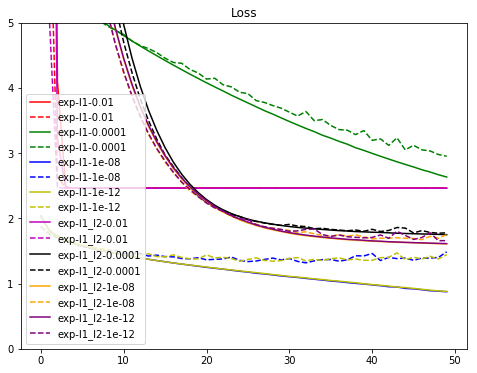

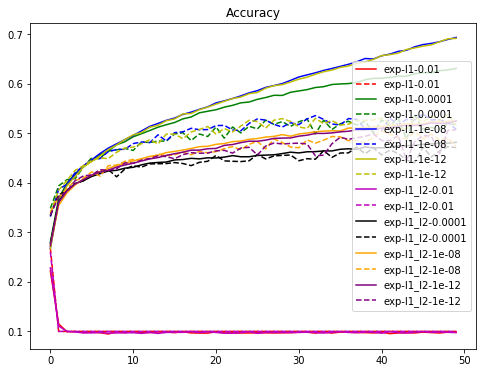

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k", "orange", "purple"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()